# 50.038 CDS 2021 Project
DONE BY: CDNerdS Team

Our attempt to run via transfer learning! Adapted from https://medium.com/@kumundzhievmaxim/pytorch-automatic-image-colorisation-7e5cd3ac514a

Our image dataset has been acquired from Kaggle:
https://www.kaggle.com/aayush9753/image-colorization-dataset

Since we have many images, for now we also include image transformations as in lab 9 too (transform, rotate, etc).


## Setup with Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#path = '/content/drive/My Drive/CDS/train_color2/' #/content/drive/MyDrive/CDS/test_color2/class

In [ ]:
!ls "/content/drive/MyDrive/CDS/train_color1/class"

image0000.jpg  image1093.jpg  image2076.jpg  image3051.jpg  image4026.jpg
image0001.jpg  image1094.jpg  image2077.jpg  image3052.jpg  image4027.jpg
image0002.jpg  image1095.jpg  image2078.jpg  image3053.jpg  image4028.jpg
image0003.jpg  image1096.jpg  image2079.jpg  image3054.jpg  image4029.jpg
image0004.jpg  image1097.jpg  image2080.jpg  image3055.jpg  image4030.jpg
image0005.jpg  image1098.jpg  image2081.jpg  image3056.jpg  image4031.jpg
image0006.jpg  image1099.jpg  image2082.jpg  image3057.jpg  image4032.jpg
image0007.jpg  image1100.jpg  image2083.jpg  image3058.jpg  image4033.jpg
image0008.jpg  image1103.jpg  image2084.jpg  image3059.jpg  image4034.jpg
image0009.jpg  image1105.jpg  image2085.jpg  image3060.jpg  image4035.jpg
image0010.jpg  image1106.jpg  image2086.jpg  image3061.jpg  image4036.jpg
image0011.jpg  image1108.jpg  image2087.jpg  image3062.jpg  image4037.jpg
image0012.jpg  image1109.jpg  image2088.jpg  image3063.jpg  image4038.jpg
image0013.jpg  image1110.jpg  image208

In [ ]:
!ls "/content/drive/MyDrive/CDS/test_color1/class"

image5000.jpg  image5153.jpg  image5298.jpg  image5454.jpg  image5600.jpg
image5001.jpg  image5154.jpg  image5299.jpg  image5455.jpg  image5601.jpg
image5004.jpg  image5155.jpg  image5300.jpg  image5456.jpg  image5602.jpg
image5005.jpg  image5156.jpg  image5301.jpg  image5457.jpg  image5603.jpg
image5006.jpg  image5157.jpg  image5302.jpg  image5458.jpg  image5604.jpg
image5007.jpg  image5158.jpg  image5303.jpg  image5460.jpg  image5605.jpg
image5008.jpg  image5159.jpg  image5304.jpg  image5461.jpg  image5606.jpg
image5010.jpg  image5160.jpg  image5305.jpg  image5462.jpg  image5607.jpg
image5011.jpg  image5161.jpg  image5306.jpg  image5463.jpg  image5608.jpg
image5012.jpg  image5162.jpg  image5307.jpg  image5464.jpg  image5609.jpg
image5013.jpg  image5163.jpg  image5308.jpg  image5466.jpg  image5610.jpg
image5014.jpg  image5164.jpg  image5309.jpg  image5467.jpg  image5611.jpg
image5015.jpg  image5166.jpg  image5311.jpg  image5468.jpg  image5612.jpg
image5016.jpg  image5167.jpg  image531

## Dataset Preprocessing
Before starting on the model, we decided to work on improving the dataset first. To note, the good news is that the dataset's images are already of a consistent size (400 x 400px), which makes processing slightly easier.

We have decided to trim the dataset of specific sets of images, such as those with heavy distortion (both colour and visually), if there are overlays like texts and stickers present, if there are multiple images in one, or if the images are otherwise unrecognisable to severe degrees.

Overall, we have cut down the sizes of each dataset (only coloured images) as follows:
- Training: 4874.
- Testing: 681.

This is slightly under the original amount we intended (5000, 700), but to ensure quality in the dataset we decided to go ahead with this selection.

## Model Setup
Now, we start actually working on the model.

In [ ]:
# imports
import os
import logging
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from torchvision import datasets

import numpy as np
from skimage.color import rgb2lab, rgb2gray,lab2rgb


/content/drive/MyDrive/CDS/train_color1/class/image4001.jpg


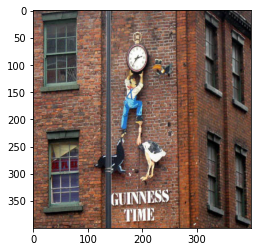

In [ ]:
if __name__ == '__main__':
    # Take a look at our input image first
    train_images = os.listdir("/content/drive/MyDrive/CDS/train_color1/class")
    validation_images = os.listdir("/content/drive/MyDrive/CDS/test_color1/class")
    img = mpimg.imread(f'{full_path}')
    full_path = os.path.join('/content/drive/MyDrive/CDS/train_color1/class', train_images[1])
    print(full_path)
    imgplot = plt.imshow(img)
    plt.show()

Customizing ResNet18 (fewer layers than ResNet50)

In [ ]:
# set up our CNN for colouring

class ColorNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorNet, self).__init__()
        mid_level_feature_size = 128

        # Handle resnet18 first
        resnet = models.resnet18(num_classes=365)
        # Alter first layer to take in greyscale/bnw inputs
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))

        # we get features midway through at layer 6
        self.mid_level_resnet = nn.Sequential(*list(resnet.children())[0:6])

        # then we do upsamples to ensure that we can expand the resolution of its features
        kernel_size = 3
        stride = 1
        padding = 1
        self.upsample = nn.Sequential(
            nn.Conv2d(mid_level_feature_size, 128, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d (128),
            nn.ReLU (),
            nn.Upsample (scale_factor=2),
            nn.Conv2d (128, 64, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d (64),
            nn.ReLU (),
            nn.Conv2d (64, 64, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d (64),
            nn.ReLU (),
            nn.Upsample (scale_factor=2),
            nn.Conv2d (64, 32, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d (32),
            nn.ReLU (),
            nn.Conv2d (32, 2, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Upsample (scale_factor=2)
        )

    def forward(self, input):
        mid_level_features = self.mid_level_resnet(input)
        output = self.upsample(mid_level_features)
        return output

Here, we make use of scikit package's conversion of colour from the RGB space to CIELAB colour and black and white/grayscale too (similar to our previous test of CIELAB colour space model on Keras). This way, we can further reduce the need to use such a large dataset (the model can on its own, convert images to black and white, as shown in our `../outputs/bnw` folder).

This means our model should effectively be able to train on *any image dataset*!

In [ ]:
# make use of ImageFolder function as from Lab 9!

class GrayscaleImageFolder(datasets.ImageFolder):
    # override getitem functin in python
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)

        if (self.transform != None):
            original = self.transform(image)
            original = np.asarray(original)
            lab = (rgb2lab(original) + 128) / 255
            ab = torch.from_numpy(lab[:, :, 1:3].transpose((2, 0, 1))).float()
            original = torch.from_numpy(rgb2gray(original)).unsqueeze(0).float()

        if (self.target_transform != None):
            target = self.target_transform (target)
        return original, ab, target

Add a metrics to follow training loss.

In [ ]:
class Metrics(object):
    def __init__(self):
        self.resnet()

    def resnet(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum/self.count


def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    plt.clf()  # clear matplotlib
    colored_image = torch.cat((grayscale_input, ab_input), 0).numpy()  # combine channels: L*a*b*
    colored_image = colored_image.transpose((1, 2, 0))  # rescale for matplotlib
    colored_image[:, :, 0:1] = colored_image[:, :, 0:1]*100
    colored_image[:, :, 1:3] = colored_image[:, :, 1:3]*255 - 128
    colored_image = lab2rgb(colored_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if ((save_path != None) and (save_name != None)):
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['bnw'], save_name), cmap='gray')
        plt.imsave(arr=colored_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
# this is to ensure that .ipynb_checkpoint files do not interfere with ImageFolder functions! Uncomment if needed, but better to manually delete from the actual Drive files because Colab is unable to detect hidden files well.
#!rm -f /content/drive/MyDrive/CDS/train_color1/class/.ipynb_checkpoints
#!rmdir /content/drive/MyDrive/CDS/test_color1/class/class/.ipynb_checkpoints

Try training on only 5 epochs for now.

Init: Raised to 30 epochs. lr 1e-2, 10 images

Final: Raised to 50 epoch, lr reduced to 1e-4, save 15 images

`See all tested values at EOF`

Unlike the source, we do not have a validation set. Instead we make use of a testing set.

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    import os
    print(f'Starting training epoch {epoch}')
    model.train()

    # Prepare value counters and timers
    batch_time = Metrics()
    data_time = Metrics()
    losses = Metrics()

    end_time = time.time()
    for i, (input_gray, input_ab, target) in enumerate (train_loader):

        # Pass dataloaders to cuda for gpu speedup
        if use_gpu:
            input_gray = input_gray.cuda()
            input_ab = input_ab.cuda()
            target = target.cuda()
        # Record time to load data (above)
        data_time.update(time.time() - end_time)

        # Run forward pass
        output_ab = model(input_gray)
        loss = criterion(output_ab, input_ab)
        losses.update(loss.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end_time)
        end_time = time.time()

        # Print model accuracy -- in the code below, val refers to value, not validation
        if (i%25 == 0):
            print('Epoch: [{0}][{1}/{2}]\t'
                   'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                   'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format (
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))

    print('Finished training epoch {}'.format(epoch))

def test(validation_model, model, criterion, save_images,epoch):
    model.eval()
    batch_time = Metrics()
    data_time = Metrics()
    losses = Metrics()

    end_time = time.time()
    is_saved = False
    for i, (input_gray, input_ab, target) in enumerate(test_loader):
        data_time.update(time.time() - end_time)

    # Pass to cuda again
    if use_gpu:
        input_gray, = input_gray.cuda()
        input_ab = input_ab.cuda()
        target = target.cuda()

    # Run model and record loss
    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if (save_images and not is_saved):
        is_saved = True
        for j in range( min( len(output_ab), 15)):  # save init 10 images, final used 15
            save_path = {'bnw': '/content/drive/MyDrive/CDS/outputs/bnw_2/', 'colorized': '/content/drive/MyDrive/CDS/outputs/color_2/'}
            save_name = 'img-{}-epoch-{}.jpg'.format(i * test_loader.batch_size + j, epoch)
            to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end_time)
    end_time = time.time()

    # report accuracy
    if (i%25 == 0):
        print('Test: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(test_loader), batch_time=batch_time, loss=losses))

    print('Finished testing.')
    return losses.avg


# run our model


if __name__ == "__main__":
    import os
    # Make folders and set parameters
    os.makedirs('/content/drive/MyDrive/CDS/outputs/color_2', exist_ok=True)
    os.makedirs('/content/drive/MyDrive/CDS/outputs/bnw_2', exist_ok=True)
    os.makedirs('/content/drive/MyDrive/CDS/checkpoints', exist_ok=True)

    # Check if GPU is available
    use_gpu = torch.cuda.is_available()

    model = ColorNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0) # tested: 1e-2,-3, inefficient -5

    # Move model and loss function to GPU
    if use_gpu:
        criterion = criterion.cuda()
        model = model.cuda()

    # Train transformation
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip()
    ])
    train_image_folder = GrayscaleImageFolder('/content/drive/MyDrive/CDS/train_color1/', train_transforms)
    train_loader = DataLoader(train_image_folder, batch_size=64, shuffle=True)

    # Test transformation
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])
    test_image_folder = GrayscaleImageFolder('/content/drive/MyDrive/CDS/test_color1/', test_transforms)
    test_loader = torch.utils.data.DataLoader(test_image_folder, batch_size=64, shuffle=False)

    save_images = True
    best_losses = 1e10
    epochs = 50

    # Train model
    for epoch in range(epochs):
        train(train_loader, model, criterion, optimizer, epoch)

        with torch.no_grad():
            losses = test(test_loader, model, criterion, save_images, epoch)

        if (losses < best_losses):
            best_losses = losses
            torch.save(model.state_dict(), f'/content/drive/MyDrive/CDS/checkpoints/model-epoch-{epoch+1}-losses-{losses:.3f}.pth')

Starting training epoch 0
Epoch: [0][0/77]	Time 35.647 (35.647)	Data 35.294 (35.294)	Loss 0.4089 (0.4089)	
Epoch: [0][25/77]	Time 33.412 (34.407)	Data 33.216 (34.215)	Loss 0.0296 (0.1506)	
Epoch: [0][50/77]	Time 35.318 (34.318)	Data 35.127 (34.130)	Loss 0.0066 (0.0830)	
Epoch: [0][75/77]	Time 35.705 (34.359)	Data 35.552 (34.173)	Loss 0.0056 (0.0578)	
Finished training epoch 0


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 179 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color 

Finished testing.
Starting training epoch 1
Epoch: [1][0/77]	Time 1.716 (1.716)	Data 1.526 (1.526)	Loss 0.0067 (0.0067)	
Epoch: [1][25/77]	Time 1.601 (1.656)	Data 1.454 (1.503)	Loss 0.0048 (0.0054)	
Epoch: [1][50/77]	Time 1.655 (1.651)	Data 1.497 (1.499)	Loss 0.0051 (0.0052)	
Epoch: [1][75/77]	Time 1.650 (1.649)	Data 1.497 (1.497)	Loss 0.0047 (0.0050)	
Finished training epoch 1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 594 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 57 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 137 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Finished testing.
Starting training epoch 2
Epoch: [2][0/77]	Time 1.718 (1.718)	Data 1.546 (1.546)	Loss 0.0043 (0.0043)	
Epoch: [2][25/77]	Time 1.651 (1.648)	Data 1.497 (1.496)	Loss 0.0039 (0.0044)	
Epoch: [2][50/77]	Time 1.657 (1.645)	Data 1.507 (1.494)	Loss 0.0044 (0.0044)	
Epoch: [2][75/77]	Time 1.648 (1.644)	Data 1.501 (1.493)	Loss 0.0037 (0.0043)	
Finished training epoch 2


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 139 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 43 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Finished testing.
Starting training epoch 3
Epoch: [3][0/77]	Time 1.707 (1.707)	Data 1.532 (1.532)	Loss 0.0038 (0.0038)	
Epoch: [3][25/77]	Time 1.645 (1.656)	Data 1.498 (1.504)	Loss 0.0036 (0.0040)	
Epoch: [3][50/77]	Time 1.662 (1.653)	Data 1.511 (1.501)	Loss 0.0042 (0.0040)	
Epoch: [3][75/77]	Time 1.630 (1.653)	Data 1.476 (1.501)	Loss 0.0037 (0.0040)	
Finished training epoch 3


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Finished testing.
Starting training epoch 4
Epoch: [4][0/77]	Time 1.725 (1.725)	Data 1.528 (1.528)	Loss 0.0039 (0.0039)	
Epoch: [4][25/77]	Time 1.643 (1.649)	Data 1.492 (1.497)	Loss 0.0037 (0.0038)	
Epoch: [4][50/77]	Time 1.641 (1.638)	Data 1.490 (1.487)	Loss 0.0043 (0.0038)	
Epoch: [4][75/77]	Time 1.602 (1.634)	Data 1.449 (1.483)	Loss 0.0029 (0.0038)	
Finished training epoch 4
Finished testing.
Starting training epoch 5
Epoch: [5][0/77]	Time 1.788 (1.788)	Data 1.610 (1.610)	Loss 0.0036 (0.0036)	
Epoch: [5][25/77]	Time 1.618 (1.648)	Data 1.468 (1.497)	Loss 0.0033 (0.0037)	
Epoch: [5][50/77]	Time 1.646 (1.640)	Data 1.495 (1.490)	Loss 0.0032 (0.0037)	
Epoch: [5][75/77]	Time 1.660 (1.645)	Data 1.506 (1.495)	Loss 0.0044 (0.0037)	
Finished training epoch 5
Finished testing.
Starting training epoch 6
Epoch: [6][0/77]	Time 1.710 (1.710)	Data 1.535 (1.535)	Loss 0.0035 (0.0035)	
Epoch: [6][25/77]	Time 1.671 (1.694)	Data 1.519 (1.542)	Loss 0.0034 (0.0037)	
Epoch: [6][50/77]	Time 1.628 (1.666)	Da

<Figure size 432x288 with 0 Axes>

In [ ]:
# attempt to find accuracy?
# -> making use of MSE w Adam Optimiser

# tested sets of params:
  # init: 30 epoch 1e-2 lr
  # 40,50 epoch 1e-2 lr
  # 30,40,50 epoch 1e-3 lr 
  # 30,40,50 epoch 1e-4 lr
  # 1e-5 and more runs a bit too slow